/home/louyl/anaconda3/envs/difflinker/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/louyl/anaconda3/envs/difflinker/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


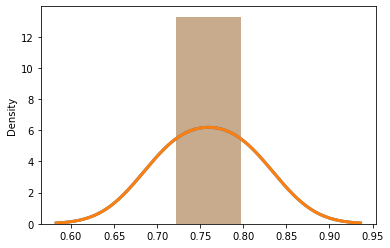

In [41]:
import seaborn as sns
from matplotlib import pyplot as plt
import os
import pandas as pd

parent_directory = '/home/louyl/DiffLinker'
logp_values = []
# sample_directories = [d for d in os.listdir(parent_directory) if d.startswith("samples")]
# sample_directories.sort(key=lambda d: int(d[7:]))

# for folder in sample_directories:
#     folder_path = os.path.join(parent_directory, folder)
#     for root, dirs, files in os.walk(folder_path):
#         for file in files:
#             if file == "rclogp_value.txt":
#                 file_path = os.path.join(root, file)
#                 with open(file_path, "r") as f:
#                     content = f.read()
#                     # print(content)
#                 logp_values.append(content)
# print(sample_directories)
# print(logp_values)

for folder in [1, 36]:
    sample_directories = f'{parent_directory}/samples{folder}'
    file_list = os.listdir(sample_directories)
    for file in file_list:
        if file == "rclogp_value.txt":
                file_path = os.path.join(sample_directories, file)
                with open(file_path, "r") as f:
                    content = f.read()
                    # print(content)
                logp_values.append(content)

# data = pd.DataFrame({'Sample': [f'samples{folder}' for folder in range(1, 40)], 'Logp Value': logp_values})

for samples, values in zip(sample_directories, logp_values):

    sns.distplot(logp_values, kde=True,
                    kde_kws={'fill': False, 'linewidth': 3},
                    label=sample_directories)




# hist=False, 


0.8385672874999999


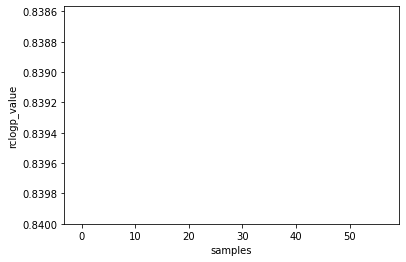

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
import os
import re
import pandas as pd
import glob

reinforce = 'rclogp'
files_path = f'/home/louyl/DiffLinker/{reinforce}/samples*'
parent_directory = glob.glob(files_path)
sorted_files = sorted(parent_directory, key=lambda x: int(re.search(r'samples(\d+)', x).group(1)))
# print(f'parent_directory = {parent_directory}')
# print(f'sorted_files = {sorted_files}')
reinforce_values = []

# 循环遍历不同的样本文件夹
for folder in sorted_files:
    files = os.listdir(folder)
    for file in files:
        if file == f'{reinforce}_value.txt':
            file_path = os.path.join(folder, file)
            with open(file_path, "r") as f:
                content = f.read()
            reinforce_values.append(float(content))

# plt.bar(reinforce_values, edgecolor="k", linewidth=1)

plt.bar(range(len(reinforce_values)), reinforce_values, edgecolor="k", linewidth=1)

plt.xlabel('samples')
plt.ylabel(f'{reinforce}_value')
plt.ylim(0.84, max(reinforce_values) + 0.02) 
print(max(reinforce_values) + 0.02)
plt.show()

In [6]:
import argparse
import os
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Crippen,AllChem
from tqdm import tqdm
from pdb import set_trace
import data.zinc.prepare_dataset as prep
import multiprocessing as mp
import sys
sys.path.append('../../')
from src.datasets import read_sdf
import subprocess
from multiprocessing import Process
from optparse import OptionParser

import seaborn as sns
from matplotlib import pyplot as plt
import os
import pandas as pd

def load_rdkit_molecule(xyz_path, obabel_path, true_frag_smi):
    if not os.path.exists(obabel_path):
        subprocess.run(f'obabel {xyz_path} -O {obabel_path}', shell=True)

    supp = Chem.SDMolSupplier(obabel_path, sanitize=False)
    mol = list(supp)[0]

    # Keeping only the biggest connected part
    mol_frags = Chem.GetMolFrags(mol, asMols=True, sanitizeFrags=False)
    mol_filtered = max(mol_frags, default=mol, key=lambda m: m.GetNumAtoms())
    try:
        mol_smi = Chem.MolToSmiles(mol_filtered)
    except RuntimeError:
        mol_smi = Chem.MolToSmiles(mol_filtered, canonical=False)

    # Retrieving linker
    true_frag = Chem.MolFromSmiles(true_frag_smi, sanitize=False)
    match = mol_filtered.GetSubstructMatch(true_frag)# 遍历match的原子和剩下的其他原子，linker的原子，需要的是找linker的原子哪些有键
    if len(match) == 0:
        linker_smi = ''
    else:
        elinker = Chem.EditableMol(mol_filtered)
        for atom in sorted(match, reverse=True):
            elinker.RemoveAtom(atom)
        linker = elinker.GetMol()
        Chem.Kekulize(linker, clearAromaticFlags=True)
        try:
            linker_smi = Chem.MolToSmiles(linker)
        except RuntimeError:
            linker_smi = Chem.MolToSmiles(linker, canonical=False)

    return mol_filtered, mol_smi, linker_smi


def load_molecules(folder, true_frag_smi):
    obabel_dir = f'{folder}/obabel'
    os.makedirs(obabel_dir, exist_ok=True)

    pred_mols = []
    pred_mols_smi = []
    pred_link_smi = []
    for fname in os.listdir(folder):
        number = fname.split('_')[0]
        if number.isdigit():
            pred_path = f'{folder}/{fname}'
            pred_obabel_path = f'{obabel_dir}/{number}_.sdf'
            mol, mol_smi, link_smi = load_rdkit_molecule(pred_path, pred_obabel_path, true_frag_smi)
            pred_mols.append(mol)
            pred_mols_smi.append(mol_smi)
            pred_link_smi.append(link_smi)

    return pred_mols, pred_mols_smi, pred_link_smi


def load_sampled_dataset(folder, idx2true_mol_smi, idx2true_frag_smi):
    pred_mols = []
    pred_mols_smi = []
    pred_link_smi = []
    true_mols_smi = []
    true_frags_smi = []

    for fname in tqdm(os.listdir(folder)):
        if fname.isdigit():
            true_mol_smi = idx2true_mol_smi[int(fname)]
            true_frag_smi = idx2true_frag_smi[int(fname)]

            mols, mols_smi, link_smi = load_molecules(f'{folder}/{fname}', true_frag_smi)
            pred_mols += mols
            pred_mols_smi += mols_smi
            pred_link_smi += link_smi
            true_mols_smi += [true_mol_smi] * len(mols)
            true_frags_smi += [true_frag_smi] * len(mols)
# fragment 原始数据 
    return pred_mols, pred_mols_smi, pred_link_smi, true_mols_smi, true_frags_smi


samples = 'rclogp/samples1'
true_smiles_path = 'datasets/zinc_final_test_smiles.smi'


true_smiles_table = pd.read_csv(true_smiles_path, sep=' ', names=['molecule', 'fragments'])
idx2true_mol_smi = dict(enumerate(true_smiles_table.molecule.values))
idx2true_frag_smi = dict(enumerate(true_smiles_table.fragments.values))

pred_mols, pred_mols_smi, pred_link_smi, true_mols_smi, true_frag_smi = load_sampled_dataset(
    folder=samples,
    idx2true_mol_smi=idx2true_mol_smi,
    idx2true_frag_smi=idx2true_frag_smi,
)

logplist = []

for m in pred_mols:
    try:
        Chem.SanitizeMol(m)
        Chem.AssignStereochemistry(m, force=True, cleanIt=True)
        mol = Chem.AddHs(m)
        logp = Crippen.MolLogP(mol)
        logplist.append(logp)
    except:
        logplist.append('no logp')
        continue

# logplist

sorted_logplist = sorted(logplist)
sorted_logplist
Clogp_list = []
goal_ClogP =2.5

for logp in logplist:
    clogp = max(0.0, 1 - (1/6)*abs(logp - goal_ClogP))
    Clogp_list.append(clogp)
# data = pd.DataFrame({'Sample': [f'samples{folder}' for folder in range(1, 40)], 'Logp Value': logplist})

# 绘制条形图
plt.figure(figsize=(12, 6))
# # for logp_value in logplist:
#     sns.distplot(logp_value, kde=True,
#                     kde_kws={'fill': False, 'linewidth': 3},
#                     label='sample_directories')
plt.xlabel('CLogp Value')
plt.ylabel('Density')
plt.title('CLogp Values Distribution(Samples50)')

# sns.distplot(logplist)

sns.distplot(Clogp_list)
plt.show()


 43%|████▎     | 174/403 [00:00<00:00, 1738.63it/s]

100%|██████████| 403/403 [00:00<00:00, 1738.05it/s]
[22:01:01] Explicit valence for atom # 27 N, 4, is greater than permitted
[22:01:01] Explicit valence for atom # 25 N, 4, is greater than permitted
[22:01:01] Explicit valence for atom # 21 C, 5, is greater than permitted
[22:01:01] Explicit valence for atom # 26 N, 4, is greater than permitted
[22:01:01] Explicit valence for atom # 14 N, 4, is greater than permitted


TypeError: '<' not supported between instances of 'float' and 'str'

100%|██████████| 403/403 [00:01<00:00, 388.68it/s]


[1.0478, 1.16903, 1.7185900000000003, 2.06185, 3.4863800000000014, 1.9104500000000009, 2.3213300000000014, 1.3908100000000008, 2.3637799999999998, 2.904600000000001, -0.04109000000000032, 2.006770000000001, 1.16881, 0.8372499999999996, 2.613740000000001, 2.0245400000000005, 1.618090000000001, 0.8715399999999999, 1.8227800000000003, 0.5598099999999998, 1.9958200000000001, 1.7899300000000005, -1.0482899999999993, 1.79486, 1.0015400000000003, 0.8840400000000002, 2.65297, 3.3059, 2.341380000000001, 2.8513500000000005, 1.6226000000000007, 2.61427, 0.1813299999999997, 2.4456300000000004, 1.0978599999999998, 1.17831, 1.0968099999999998, 0.6778899999999998, 2.4947400000000006, 0.8093499999999998, 2.0917100000000004, 2.294350000000001, 4.478700000000001, 1.8903200000000004, 0.9785299999999997, -0.7002800000000003, 0.8315099999999997, 1.6984400000000006, 1.3571000000000006, 1.9990999999999999, 1.1699599999999999, 3.766660000000001, 1.5898599999999998, 1.55494, 1.1991000000000003, 3.2548400000000

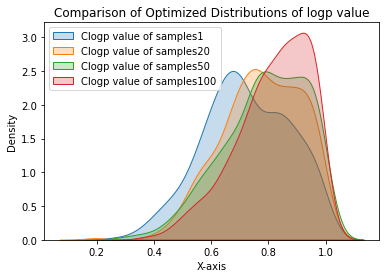

In [6]:
import argparse
import os
import pandas as pd
from rdkit import Chem, RDLogger
from rdkit.Chem import Crippen,AllChem
from tqdm import tqdm
from pdb import set_trace
import data.zinc.prepare_dataset as prep
import multiprocessing as mp
import sys
sys.path.append('../../')
from src.datasets import read_sdf
import subprocess
from multiprocessing import Process
from optparse import OptionParser

import seaborn as sns
from matplotlib import pyplot as plt
import os
import pandas as pd
import logging

# 禁用 RDKit 警告信息
RDLogger.DisableLog('rdApp.*')

def load_rdkit_molecule(xyz_path, obabel_path, true_frag_smi):
    if not os.path.exists(obabel_path):
        subprocess.run(f'obabel {xyz_path} -O {obabel_path}', shell=True)

    supp = Chem.SDMolSupplier(obabel_path, sanitize=False)
    mol = list(supp)[0]

    # Keeping only the biggest connected part
    mol_frags = Chem.GetMolFrags(mol, asMols=True, sanitizeFrags=False)
    mol_filtered = max(mol_frags, default=mol, key=lambda m: m.GetNumAtoms())
    try:
        mol_smi = Chem.MolToSmiles(mol_filtered)
    except RuntimeError:
        mol_smi = Chem.MolToSmiles(mol_filtered, canonical=False)

    # Retrieving linker
    true_frag = Chem.MolFromSmiles(true_frag_smi, sanitize=False)
    match = mol_filtered.GetSubstructMatch(true_frag)# 遍历match的原子和剩下的其他原子，linker的原子，需要的是找linker的原子哪些有键
    if len(match) == 0:
        linker_smi = ''
    else:
        elinker = Chem.EditableMol(mol_filtered)
        for atom in sorted(match, reverse=True):
            elinker.RemoveAtom(atom)
        linker = elinker.GetMol()
        Chem.Kekulize(linker, clearAromaticFlags=True)
        try:
            linker_smi = Chem.MolToSmiles(linker)
        except RuntimeError:
            linker_smi = Chem.MolToSmiles(linker, canonical=False)

    return mol_filtered, mol_smi, linker_smi


def load_molecules(folder, true_frag_smi):
    obabel_dir = f'{folder}/obabel'
    os.makedirs(obabel_dir, exist_ok=True)

    pred_mols = []
    pred_mols_smi = []
    pred_link_smi = []
    for fname in os.listdir(folder):
        number = fname.split('_')[0]
        if number.isdigit():
            pred_path = f'{folder}/{fname}'
            pred_obabel_path = f'{obabel_dir}/{number}_.sdf'
            mol, mol_smi, link_smi = load_rdkit_molecule(pred_path, pred_obabel_path, true_frag_smi)
            pred_mols.append(mol)
            pred_mols_smi.append(mol_smi)
            pred_link_smi.append(link_smi)

    return pred_mols, pred_mols_smi, pred_link_smi


def load_sampled_dataset(folder, idx2true_mol_smi, idx2true_frag_smi):
    pred_mols = []
    pred_mols_smi = []
    pred_link_smi = []
    true_mols_smi = []
    true_frags_smi = []

    for fname in tqdm(os.listdir(folder)):
        if fname.isdigit():
            true_mol_smi = idx2true_mol_smi[int(fname)]
            true_frag_smi = idx2true_frag_smi[int(fname)]

            mols, mols_smi, link_smi = load_molecules(f'{folder}/{fname}', true_frag_smi)
            pred_mols += mols
            pred_mols_smi += mols_smi
            pred_link_smi += link_smi
            true_mols_smi += [true_mol_smi] * len(mols)
            true_frags_smi += [true_frag_smi] * len(mols)
# fragment 原始数据 
    return pred_mols, pred_mols_smi, pred_link_smi, true_mols_smi, true_frags_smi

samples_no = [1,20,50,100]
true_smiles_path = 'datasets/zinc_final_test_smiles.smi'

true_smiles_table = pd.read_csv(true_smiles_path, sep=' ', names=['molecule', 'fragments'])
idx2true_mol_smi = dict(enumerate(true_smiles_table.molecule.values))
idx2true_frag_smi = dict(enumerate(true_smiles_table.fragments.values))

Clogp_dict = {} 
for i in samples_no:
    samples = f'rclogp/samples{i}'
    Clogplist_key = f'samples{i}'
    pred_mols, pred_mols_smi, pred_link_smi, true_mols_smi, true_frag_smi = load_sampled_dataset(
        folder=samples,
        idx2true_mol_smi=idx2true_mol_smi,
        idx2true_frag_smi=idx2true_frag_smi,
    )
    logplist = []
    for m in pred_mols:
        try:
            Chem.SanitizeMol(m)
            Chem.AssignStereochemistry(m, force=True, cleanIt=True)
            mol = Chem.AddHs(m)
            logp = Crippen.MolLogP(mol)
            logplist.append(logp)
        except:
            continue
    Clogp_list = []
    goal_ClogP = 2.5
    for logp in logplist:
        clogp = max(0.0, 1 - (1/6) * abs(logp - goal_ClogP))
        Clogp_list.append(clogp)
    Clogp_dict[Clogplist_key] = Clogp_list


print(logplist)

custom_colors = ["red", "green", "blue", "purple"]


# 绘制分布图
for Clogplist_key, Clogp_list in Clogp_dict.items():
    # sns.kdeplot(Clogp_list, color=sns.color_palette("husl")[len(plt.legend().get_lines())], label=f'{Clogplist_key}', shade=True)
    sns.kdeplot(Clogp_list, label=f'Clogp value of {Clogplist_key}', shade=True)


# 添加标签和标题
plt.xlabel('X-axis')
plt.ylabel('Density')
plt.title('Comparison of Optimized Distributions of logp value')

# 显示图例
plt.legend(bbox_to_anchor=(0, 1), loc='upper left')

# 显示图形
plt.show()




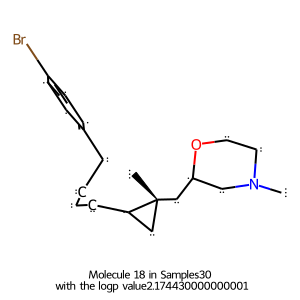

In [17]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import PandasTools
from rdkit.Chem import Crippen
import pandas as pd

reinforce = 'sa'
samples= 30
compounds= 18

sdf_supplier = Chem.SDMolSupplier(f"/home/louyl/DiffLinker/{reinforce}/samples{samples}/{compounds}/obabel/0_.sdf")

m = sdf_supplier[0]
Chem.SanitizeMol(m)
Chem.AssignStereochemistry(m, force=True, cleanIt=True)
mol = Chem.AddHs(m)
# mol.ClearConformers()
logp = Crippen.MolLogP(mol)

# mol 
molecule = [mol for mol in sdf_supplier]

titles=[f"Molecule {compounds} in Samples{samples}\n with the logp value{logp}"]

img = Draw.MolsToGridImage(molecule, molsPerRow=1, subImgSize=(300, 300),legends=titles)
img

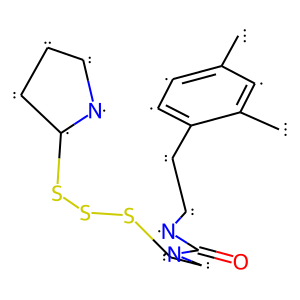

In [12]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import PandasTools
from rdkit.Chem import Crippen
import pandas as pd
import subprocess

reinforce = 'rclogp'
samples= 100
compounds= 0

mol_sdf = Chem.SDMolSupplier(f"/home/louyl/DiffLinker/{reinforce}/samples{samples}/{compounds}/obabel/0_.sdf")
# frag_xyz = f"/home/louyl/DiffLinker/{reinforce}/samples{samples}/{compounds}/frag_.xyz"
# frag_obb = Chem.SDMolSupplier(f"/home/louyl/DiffLinker/{reinforce}/samples{samples}/{compounds}/obabel/0_frag.sdf")
# if not os.path.exists(frag_obb):
#     subprocess.run(f'obabel {frag_xyz} -O {frag_obb}', shell=True)
# frag_sdf = Chem.SDMolSupplier(f"/home/louyl/DiffLinker/{reinforce}/samples{samples}/{compounds}/obabel/0_frag.sdf")
m = mol_sdf[0]
Chem.RemoveAllHs(m)
# frag = frag_sdf[0]
# Chem.SanitizeMol(m)
# Chem.AssignStereochemistry(m, force=True, cleanIt=True)
# mol = Chem.AddHs(m)
# mol_smi = Chem.MolToSmiles(mol)
# molecule = Chem.MolFromSmiles(mol_smi)

# molecule
logp = Crippen.MolLogP(mol)

titles=[f"Molecule {compounds} in Samples{samples}\n with the logp value{logp}"]

img = Draw.MolToImage(m, molsPerRow=1, subImgSize=(300, 300),legends=titles)
img

In [5]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Crippen

# 读取包含信息的CSV文件
csv_file_path = '/home/louyl/DiffLinker/rclogp/out_dir100/template_table.csv'  
out_csv = f'/home/louyl/DiffLinker/data/test.csv'

df = pd.read_csv(csv_file_path)

# 存储logP值的列
df['logP'] = None

# 计算每个分子的logP值
for index, row in df.iterrows():
    smiles = row['molecule']
    mol = Chem.MolFromSmiles(smiles)
    
    if mol is not None:
        # 添加氢原子
        mol = Chem.AddHs(mol)
        # 计算logP值
        logp = Crippen.MolLogP(mol)
        # 将logP值存储到 DataFrame 中
        df.at[index, 'logP'] = logp

# # 打印结果
# print(df[['uuid', 'molecule', 'logP']])
        
# 将结果保存到新的CSV文件
df[['uuid', 'molecule', 'logP']].to_csv(out_csv, index=False)

In [7]:
# calculate logp value of a single smi string
from rdkit import Chem
from rdkit.Chem import Crippen

# 输入 SMILES 表示的分子
smiles = "O=CN1CCN(C2CCS(=O)(=O)C2)CC1CC1C2C[C@]12CC1=CC(C(F)(F)F)=CC=C1"

# 将 SMILES 转换为 RDKit 的分子对象
mol = Chem.MolFromSmiles(smiles)

# 如果分子对象不为空，则计算 LogP 值
if mol is not None:
    Chem.SanitizeMol(mol)
    Chem.AssignStereochemistry(mol, force=True, cleanIt=True)
    mol_with_h = Chem.AddHs(mol)
    logp_value = Crippen.MolLogP(mol_with_h)
    print(f"LogP value for the molecule: {logp_value}")
else:
    print("Invalid SMILES representation.")

LogP value for the molecule: 2.6038000000000006


In [4]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import PandasTools
from rdkit.Chem import Crippen
import pandas as pd
import os
from src.utils import disable_rdkit_logging

disable_rdkit_logging()

out_csv = f'/home/louyl/DiffLinker/data/test1.csv'

samples = 100
samples_path = f"/home/louyl/DiffLinker/rclogp/samples{samples}"
subfolders = os.listdir(samples_path)
logplist = []
for i in range(len(subfolders)):
    sdf_path = os.path.join(samples_path, str(i), "obabel", "0_.sdf")

    try:
        sdf_supplier = Chem.SDMolSupplier(sdf_path)
        m = sdf_supplier[0]
        Chem.SanitizeMol(m)
        Chem.AssignStereochemistry(m, force=True, cleanIt=True)
        mol = Chem.AddHs(m)
        logp = Crippen.MolLogP(mol)
        logplist.append(logp)
    except:
        logplist.append('no logp')
        continue
# Convert the list to a DataFrame
df = pd.DataFrame({'LogP': logplist})

# Save the DataFrame to a CSV file
df.to_csv(out_csv, index=False)

In [ ]:
from rdkit import Chem
from rdkit.Chem import QED, Crippen, Descriptors

# 输入 SMILES 表示的分子
smiles = "CCO"

# 将 SMILES 转换为 RDKit 的分子对象
mol = Chem.MolFromSmiles(smiles)

# 如果分子对象不为空，则计算 QED 值和 SA 值
if mol is not None:
    Chem.SanitizeMol(mol)
    Chem.AssignStereochemistry(mol, force=True, cleanIt=True)
    mol_with_h = Chem.AddHs(mol)

    # 计算 QED 值
    qed_value = QED.qed(mol_with_h)
    print(f"QED value for the molecule: {qed_value}")

    # 计算 SA 值
    sa_value = Descriptors.NumRotatableBonds(mol_with_h) + Descriptors.NumHDonors(mol_with_h) + \
                Descriptors.NumHAcceptors(mol_with_h) + Descriptors.NumAliphaticCarbocycles(mol_with_h)
    print(f"SA value for the molecule: {sa_value}")
else:
    print("Invalid SMILES representation.")